In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate1 as sr1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
# warnings.filterwarnings('ignore')

**Q0: How is $Z:= \frac{1}{D_r}\mathbb E[\text{\rm zero cols of W}]$ related to $p_{\rm good}$? A: There's a clear pattern of rising till an optimal $p_{\rm good}$ is reached and then falling.**

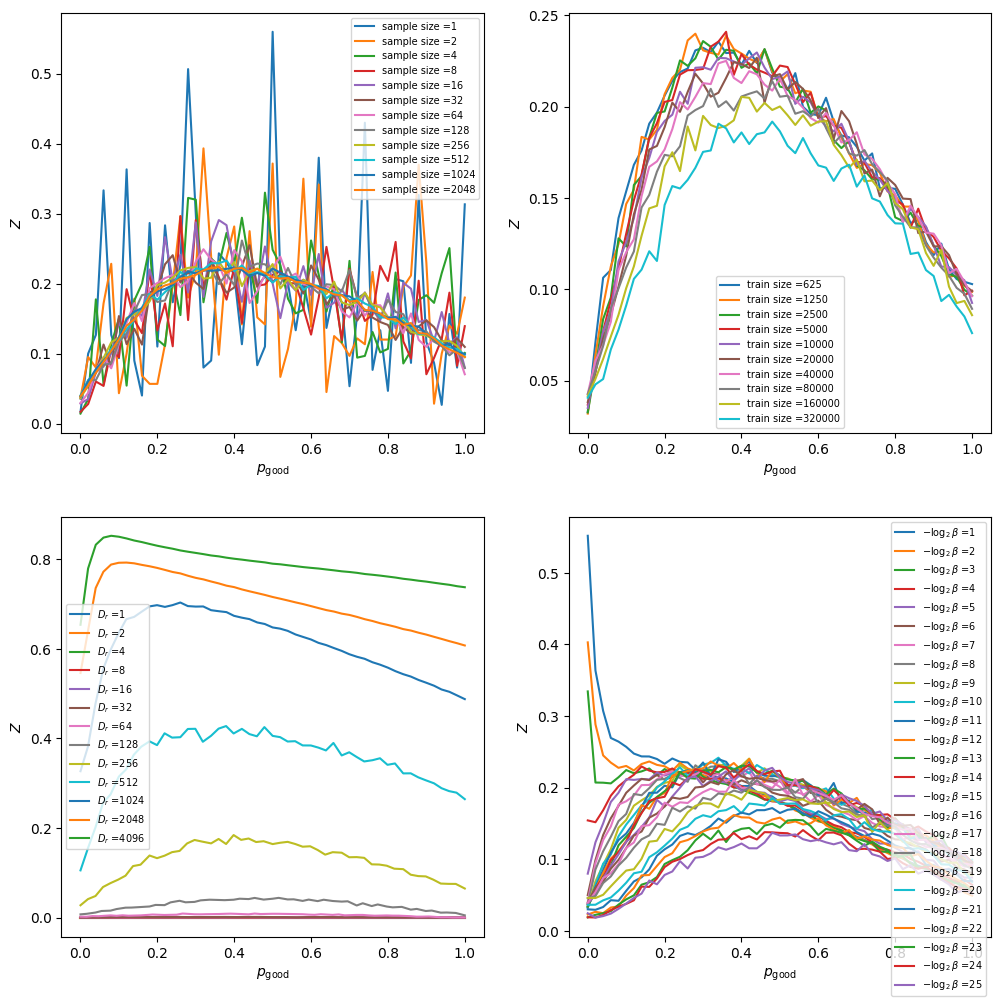

In [4]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs = [ax1, ax2, ax3, ax4]

save_folders = ['../data/L63-Strategy-varying-samplesize/', '../data/L63-Strategy-varying-trainsize/',\
                '../data/L63-Strategy-varying-featuresize/', '../data/L63-Strategy-varying-beta/']
Ms = [12, 10, 13, 25]
values = [[2**n for n in range(Ms[0])], [625*2**n for n in range(Ms[1])], [2**n for n in range(Ms[2])], [n for n in range(1, Ms[3]+1)]]
values_ = [[n for n in range(Ms[0])], [np.log2(625*2**n) for n in range(Ms[1])], [n for n in range(Ms[2])], [n for n in range(1, Ms[3]+1)]]
vars = ['sample size', 'train size', r'$D_r$', r'$-\log_2\beta$']
vars_ = [r'$\log_2(\text{sample size})$', r'$\log_2(\text{train size})$', r'$\log_2(D_r)$', r'$-\log_2\beta$']

for i in range(4):
    for item in values[i]:
        
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        zc = bsa.get_line('0_cols_W')[0]
        
        axs[i].plot(bsa.percents, zc, label=f'{vars[i]} ={item}')
        # axs[i].scatter(bsa.percents, zc, c='b')
    axs[i].set_xlabel(r'$p_{\rm good}$')
    axs[i].set_ylabel(r'$Z$')
    axs[i].legend(fontsize=7)
    # axs[i].set_aspect('equal')
plt.savefig(f'../data/plots/Z_vs_p_good.png')

**Q1: $Z$ is nearly an affine function of $p_{\rm good}$ for smaller and larger values $p_{\rm good}$. Let the correspodning slopes be $S_L$ and $S_R$ respectively. How do $S_L, S_R$ change with hyperparameters? A: $S_R$ seems to be always a constant!**

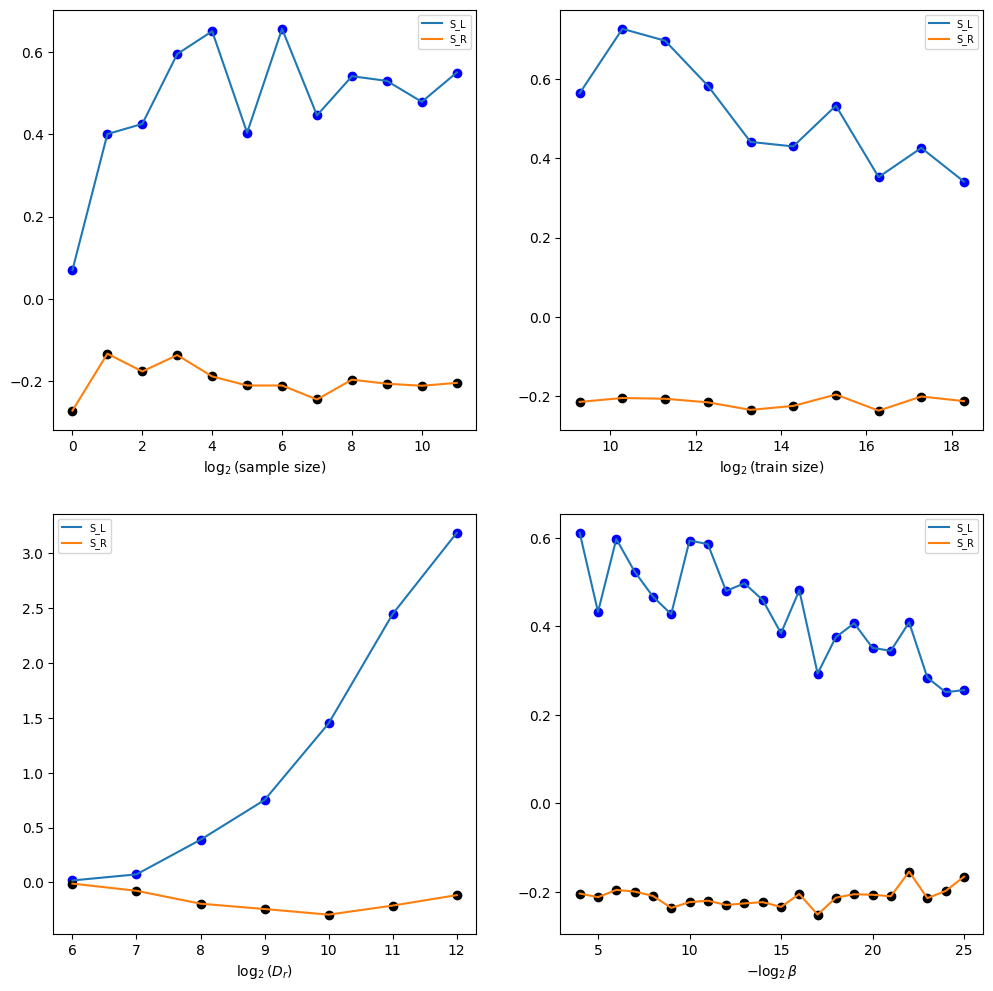

In [5]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs = [ax1, ax2, ax3, ax4]


Ms1 = [12, 10, 6, 22]
values1 = [[2**n for n in range(Ms[0])], [625*2**n for n in range(Ms[1])], [2**n for n in range(6, Ms[2])], [n for n in range(4, Ms[3]+1)]]
values1_ = [[n for n in range(Ms[0])], [np.log2(625*2**n) for n in range(Ms[1])], [n for n in range(6, Ms[2])], [n for n in range(4, Ms[3]+1)]]


for i in range(4):
    S_L = np.zeros(len(values1[i]))
    S_R = np.zeros(len(values1[i]))
    for j, item in enumerate(values1[i]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        zc = bsa.get_line('0_cols_W')[0]
        pg = bsa.percents
        p, q = np.argmax(zc), np.argmax(zc[::-1])
        l = max(p, len(zc)-1-q)
        m = min(int(l/2.), 10)
        
        reg_L = stats.linregress(pg[:l], zc[:l])
        m = min(int((len(zc)-l)/2.), 10)
        reg_R = stats.linregress(pg[l:], zc[l:])
        S_L[j] = reg_L.slope
        S_R[j] = reg_R.slope

    axs[i].plot(values1_[i], S_L, label=f'S_L')
    axs[i].scatter(values1_[i], S_L, c='b')
    axs[i].plot(values1_[i], S_R, label=f'S_R')
    axs[i].scatter(values1_[i], S_R, c='black')
    axs[i].set_xlabel(vars_[i])
    # axs[i].set_ylabel('$S_L$')
    axs[i].legend(fontsize=7)
 
plt.savefig(f'../data/plots/slopes_Z_vs_p_good.png')

**Q2: If one defines $p^*_W:= {\rm argmax}_{p_{\rm good}}Z(p_{\rm good})$, is $\frac{dp^*_W}{dD_r}\le0$? If we define $p^*_G(\varepsilon):=\min\{1, \inf\{p_{\rm good}:P(\tau_f>4|p_{\rm good})>\varepsilon\}\}$, is $\frac{dp^*_G}{dD_r}\le0$? How are $p^*_W, p^*_G$ related? A:Beyond the optimal $D_r$ they are positively correleated.**

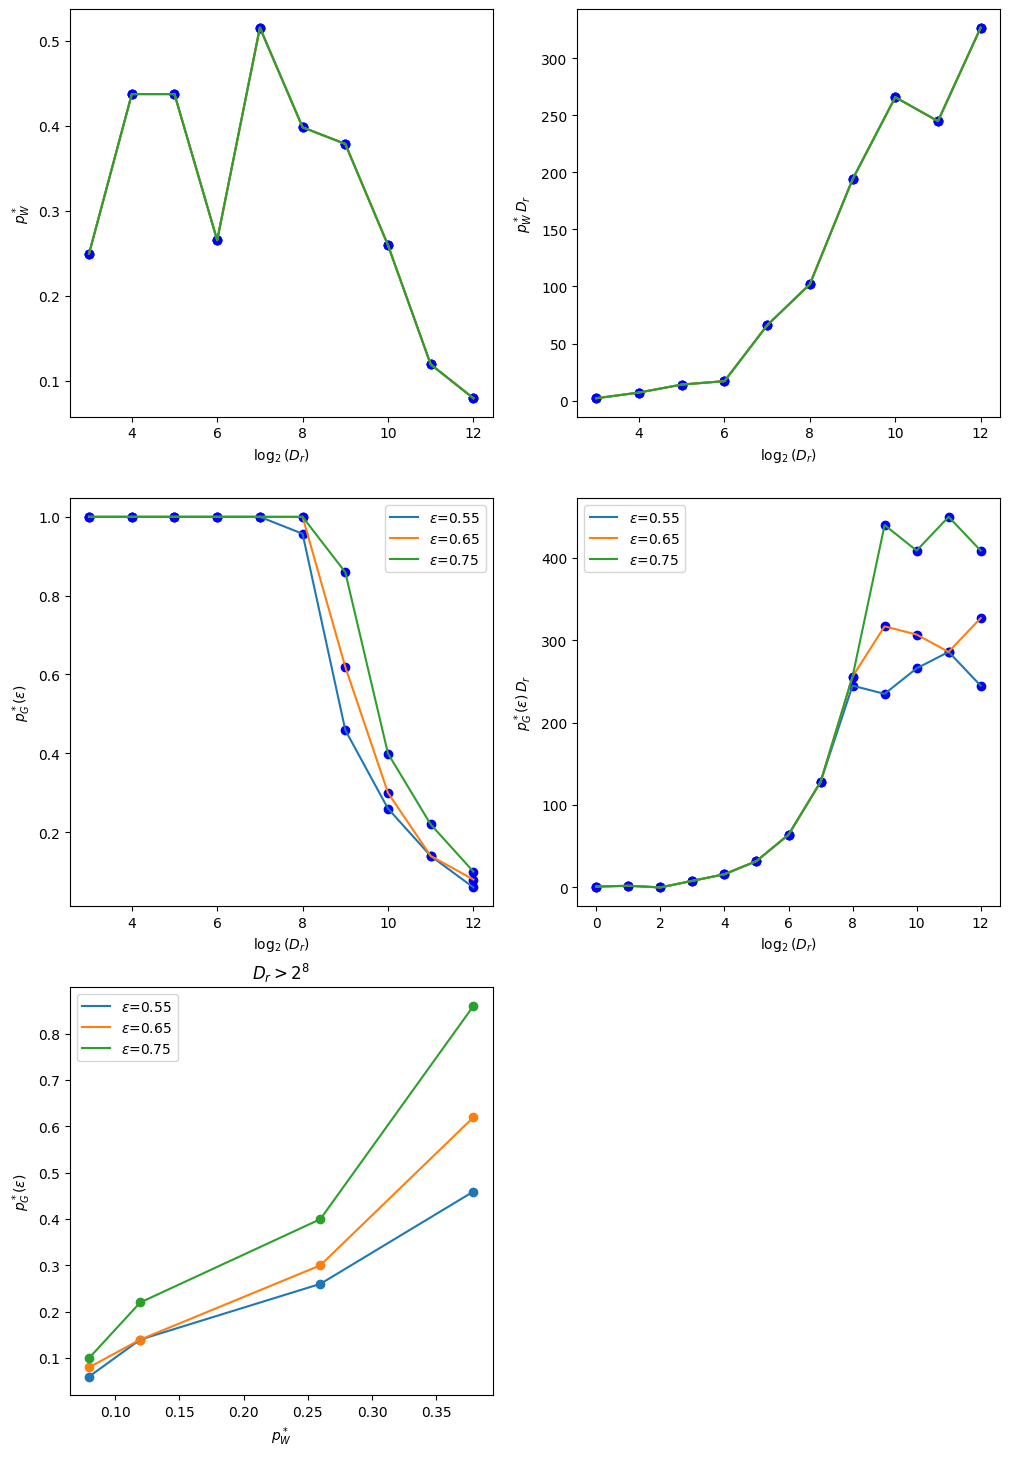

In [9]:
fig = plt.figure(figsize=(12, 18))
ax = fig.add_subplot(321)
ax1 = fig.add_subplot(322)
ax2 = fig.add_subplot(323)
ax3 = fig.add_subplot(324)
ax4 = fig.add_subplot(325)
I = 2
offset = 3
p_W = np.zeros(Ms[I])
p_G = np.zeros(Ms[I]) 
for threshold in [0.55, 0.65, 0.75]:
    for i, D_r in enumerate(values[I]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[I] + str(D_r))
        p_G[i], p_W[i] = [bsa.percents[j] for j in bsa.compute_optimal_p(gen=4., threshold=threshold)]
    
    ax.plot(np.log2(values[I])[offset:], p_W[offset:], label=f'threshold={threshold}')
    ax.scatter(np.log2(values[I])[offset:], p_W[offset:], c='b')
    ax.set_xlabel(r'$\log_2(D_r)$')
    ax.set_ylabel(r'$p^*_{W}$')
    
    
    ax1.plot(np.log2(values[I])[offset:], ((values[I])*(p_W))[offset:], label=f'threshold={threshold}')
    ax1.scatter(np.log2(values[I])[offset:], ((values[I])*(p_W))[offset:], c='b')
    ax1.set_xlabel(r'$\log_2(D_r)$')
    ax1.set_ylabel(r'$p^*_{W}\,D_r$')

    ax2.plot(np.log2(values[I])[offset:], p_G[offset:], label=fr'$\varepsilon$={threshold}')
    ax2.scatter(np.log2(values[I])[offset:], p_G[offset:], c='b')
    ax2.set_xlabel(r'$\log_2(D_r)$')
    ax2.set_ylabel(r'$p^*_{G}(\varepsilon)$')
    
    
    ax3.plot(np.log2(values[I]), (values[I])*(p_G), label=fr'$\varepsilon$={threshold}')
    ax3.scatter(np.log2(values[I]), (values[I])*(p_G), c='b')
    ax3.set_xlabel(r'$\log_2(D_r)$')
    ax3.set_ylabel(r'$p^*_{G}(\varepsilon)\,D_r$')
    if True:#threshold == 0.65:
        ax4.plot(p_W[-4:], (p_G)[-4:], label=fr'$\varepsilon$={threshold}')
        ax4.scatter(p_W[-4:], (p_G)[-4:])
        ax4.set_xlabel(r'$p^*_W$')
        ax4.set_ylabel(r'$p^*_{G}(\varepsilon)$')
        ax4.set_title(r'$D_r>2^8$')

# ax.legend()
# ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig(f'../data/plots/optimal_p_vs_D_r.png')

**Q3: How does the standard deviation of forecast time change with hyperparameters? A: The coefficient of variation decreases with increasing training size $=N$ and $D_r$. Also, as expected $\frac{d\mathbb E[\tau_f]}{dD_r}, \frac{d\mathbb E[\tau_f]}{dN}\ge0$.**

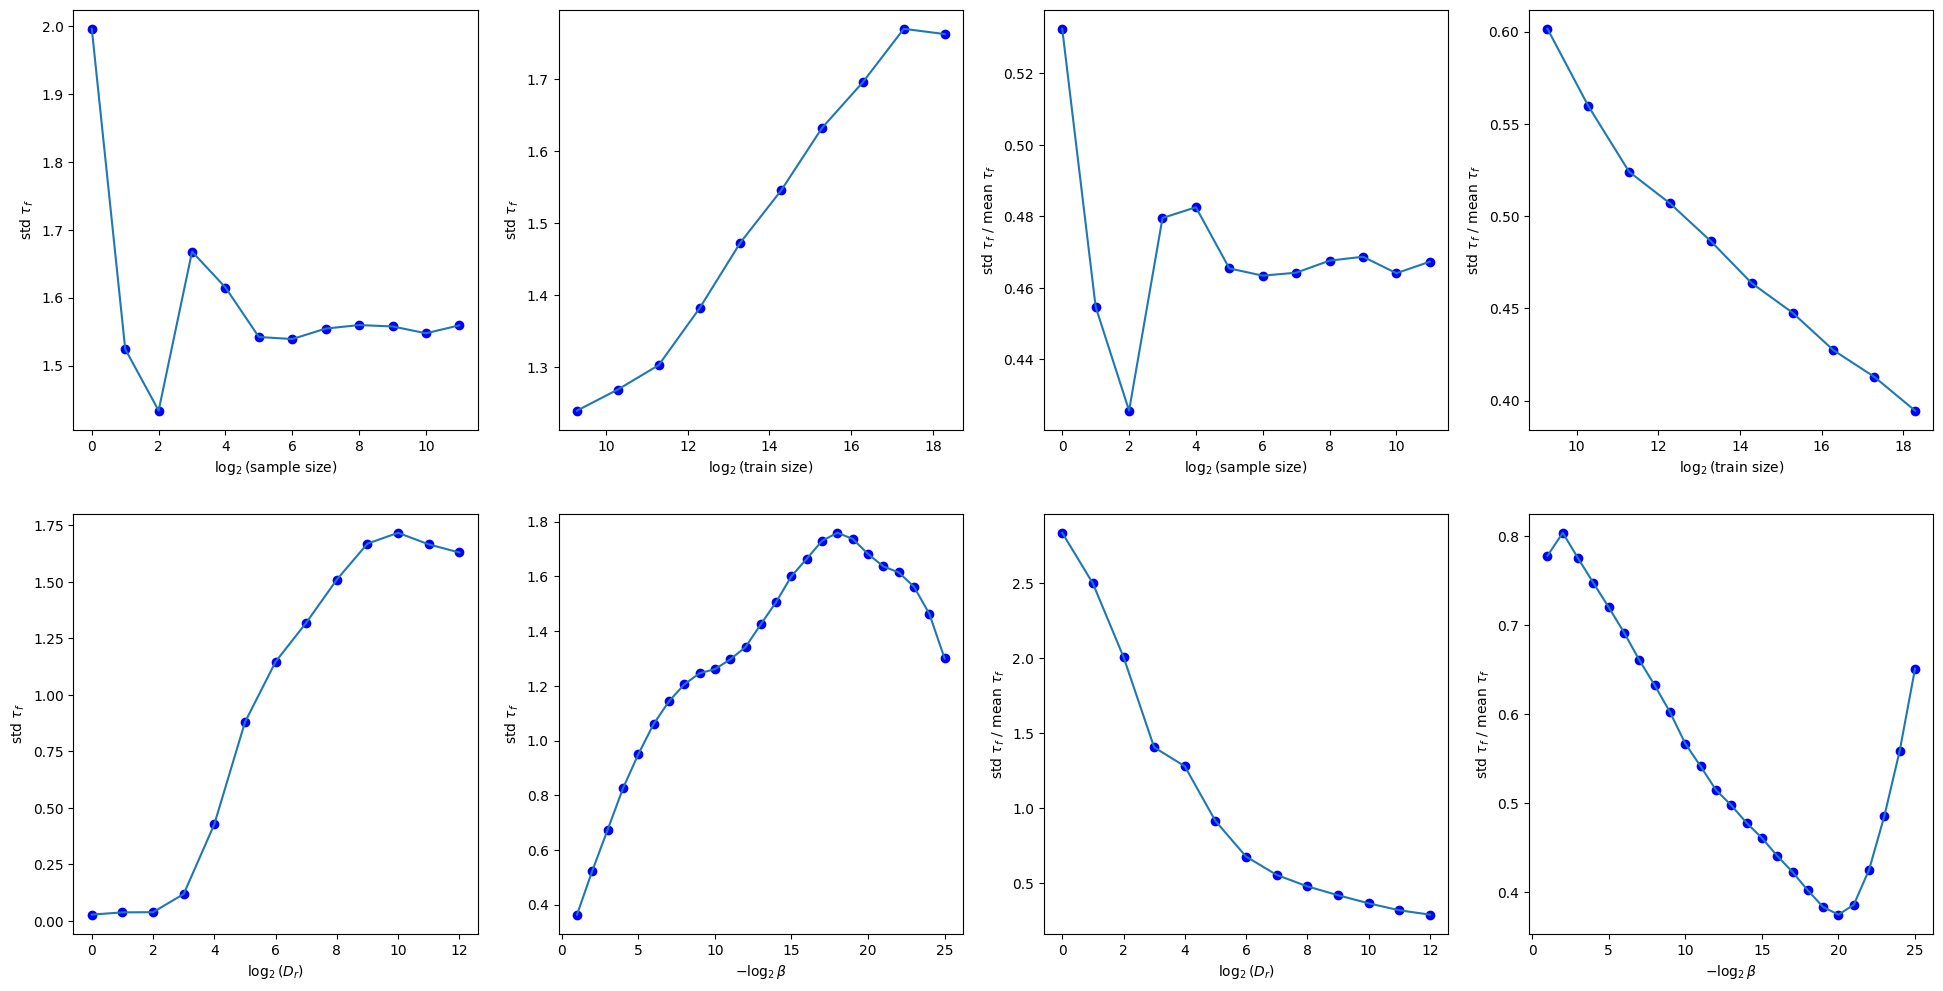

In [28]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(241)
ax1 = fig.add_subplot(242)
ax2 = fig.add_subplot(245)
ax3 = fig.add_subplot(246)

ax4 = fig.add_subplot(243)
ax5 = fig.add_subplot(244)
ax6 = fig.add_subplot(247)
ax7 = fig.add_subplot(248)

axs = [ax, ax1, ax2, ax3]
axs_ = [ax4, ax5, ax6, ax7]
for i in range(4):
    mean = np.zeros(Ms[i])
    std = np.zeros(Ms[i])
    for j, item in enumerate(values[i]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        arr = bsa.get_data()['tau_f_se']
        mean[j] = arr.mean()
        std[j] = arr.std()
    axs[i].plot(values_[i], std, label=f'{vars[i]} ={item}')
    axs[i].scatter(values_[i], std, c='b')
    axs[i].set_xlabel(f'{vars_[i]}')
    axs[i].set_ylabel(r'std $\tau_f$')

    axs_[i].plot(values_[i], (std/mean), label=f'{vars[i]} ={item}')
    axs_[i].scatter(values_[i], (std/mean), c='b')
    axs_[i].set_xlabel(f'{vars_[i]}')
    axs_[i].set_ylabel(r'std $\tau_f$ / mean $\tau_f$')
plt.savefig(f'../data/plots/ratio_std_mean_tau_f.png')

**Q4: How does $\mathbb E[||W||]$ change with hyperparameters? A: As expected $\beta$ controls $||W||$ but it also increases with $N$.**

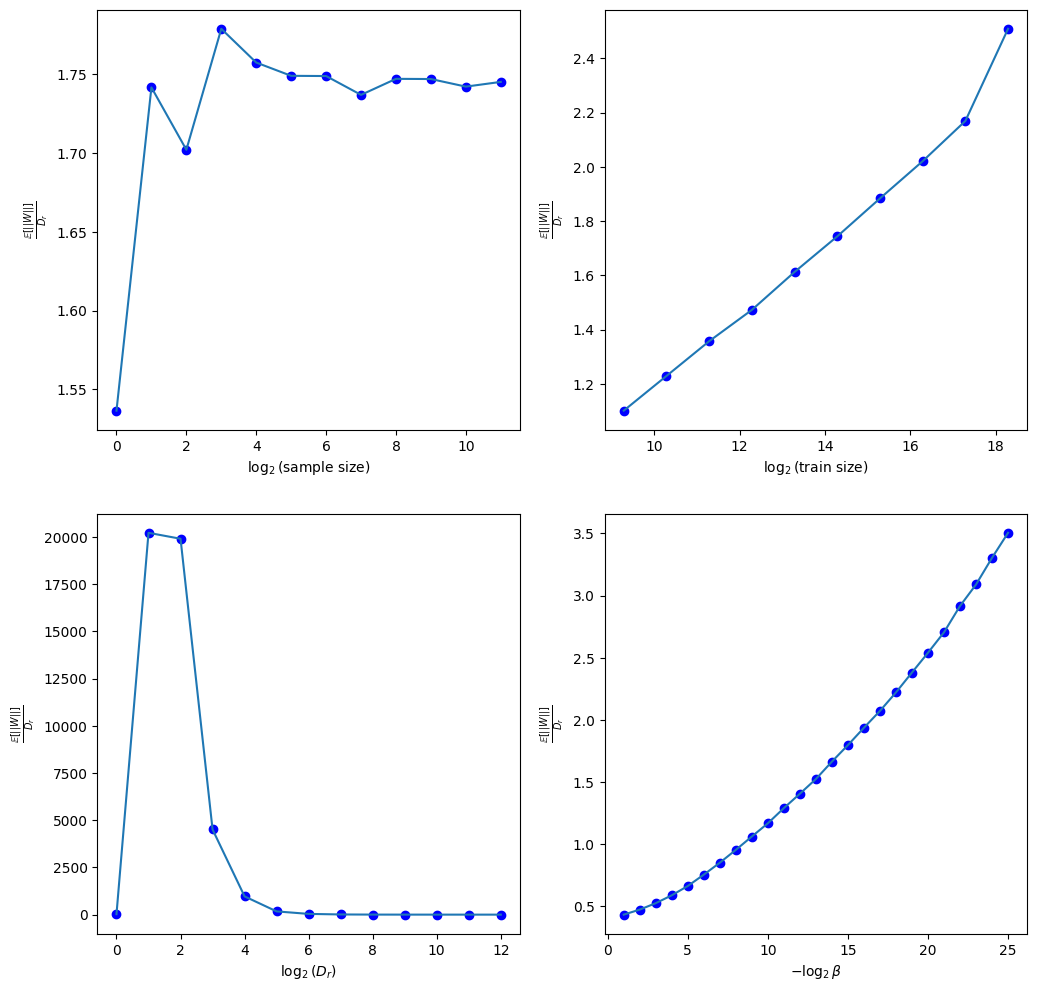

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

axs = [ax, ax1, ax2, ax3]

for i in range(4):
    mean = np.zeros(Ms[i])
    std = np.zeros(Ms[i])
    for j, item in enumerate(values[i]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        arr = bsa.get_data()['||W||']
        mean[j] = arr.mean()
        # std[j] = arr.std()
    axs[i].plot(values_[i], mean, label=f'{vars[i]} ={item}')
    axs[i].scatter(values_[i], mean, c='b')
    axs[i].set_xlabel(f'{vars_[i]}')
    axs[i].set_ylabel(r'$\frac{\mathbb{E}[||W||]}{D_r}$')

plt.savefig(f'../data/plots/W_norm.png')

**Q5: How does $\mathbb E[B]$ change with hyperparameters where $B$ is the fraction of bad features? A: It's a function of (only) $p_{\rm extreme}$. Saturates at $\approx 0.2492$ for this problem. This happens because $\frac{1}{51}\sum_{p=0}^{50}\frac{(1-2p)}{100}=0.25$ :)**

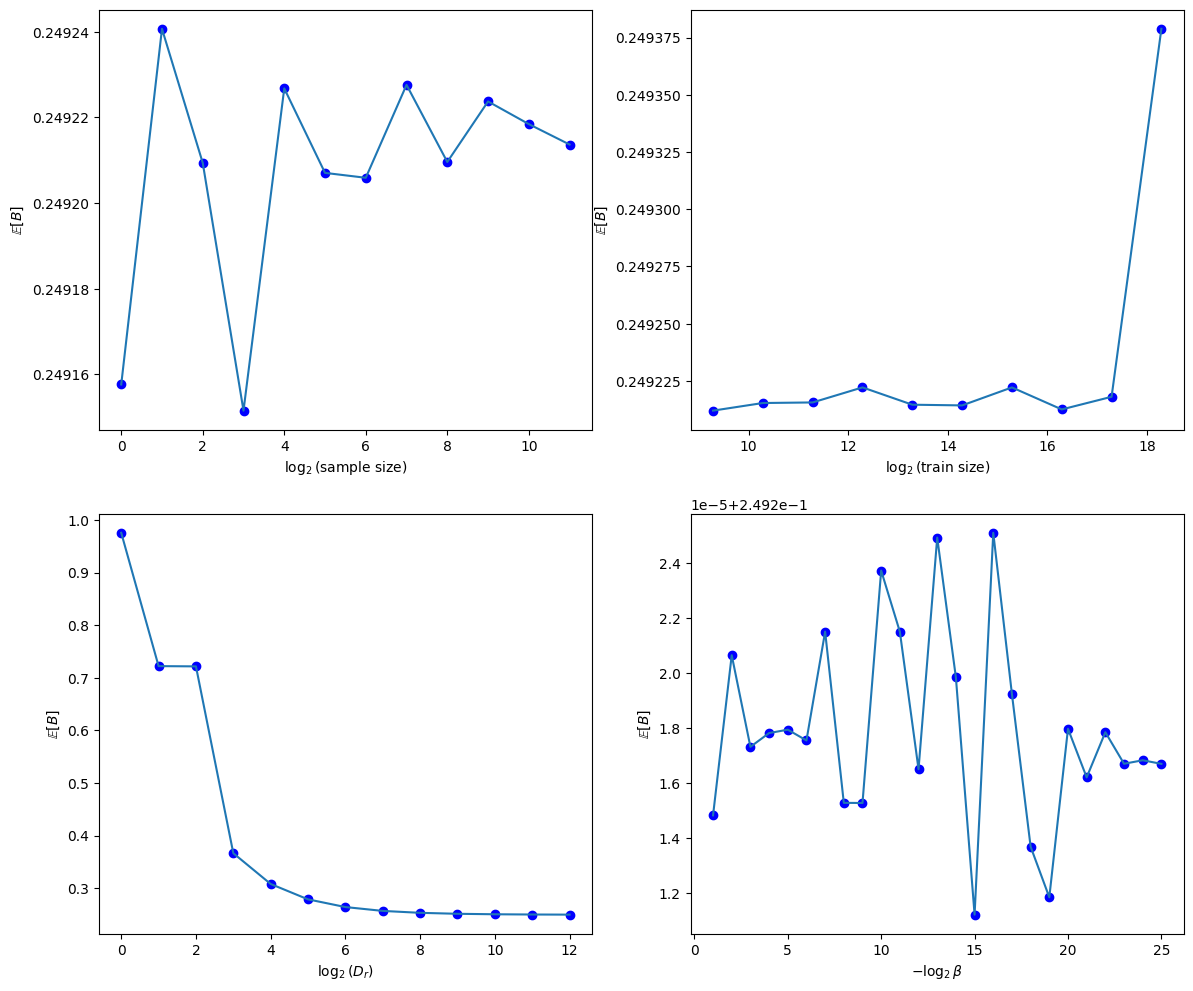

In [14]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

axs = [ax, ax1, ax2, ax3]

for i in range(4):
    mean = np.zeros(Ms[i])
    std = np.zeros(Ms[i])
    for j, item in enumerate(values[i]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        arr = bsa.get_data()['avg_bad_features']
        mean[j] = arr.mean()
        # std[j] = arr.std()
    axs[i].plot(values_[i], mean, label=f'{vars[i]} ={item}')
    axs[i].scatter(values_[i], mean, c='b')
    axs[i].set_xlabel(f'{vars_[i]}')
    axs[i].set_ylabel(r'$\mathbb{E}[B]$')

plt.savefig(f'../data/plots/bad-features.png')

**Q6: How does $Z$ change with hyperparameters?**

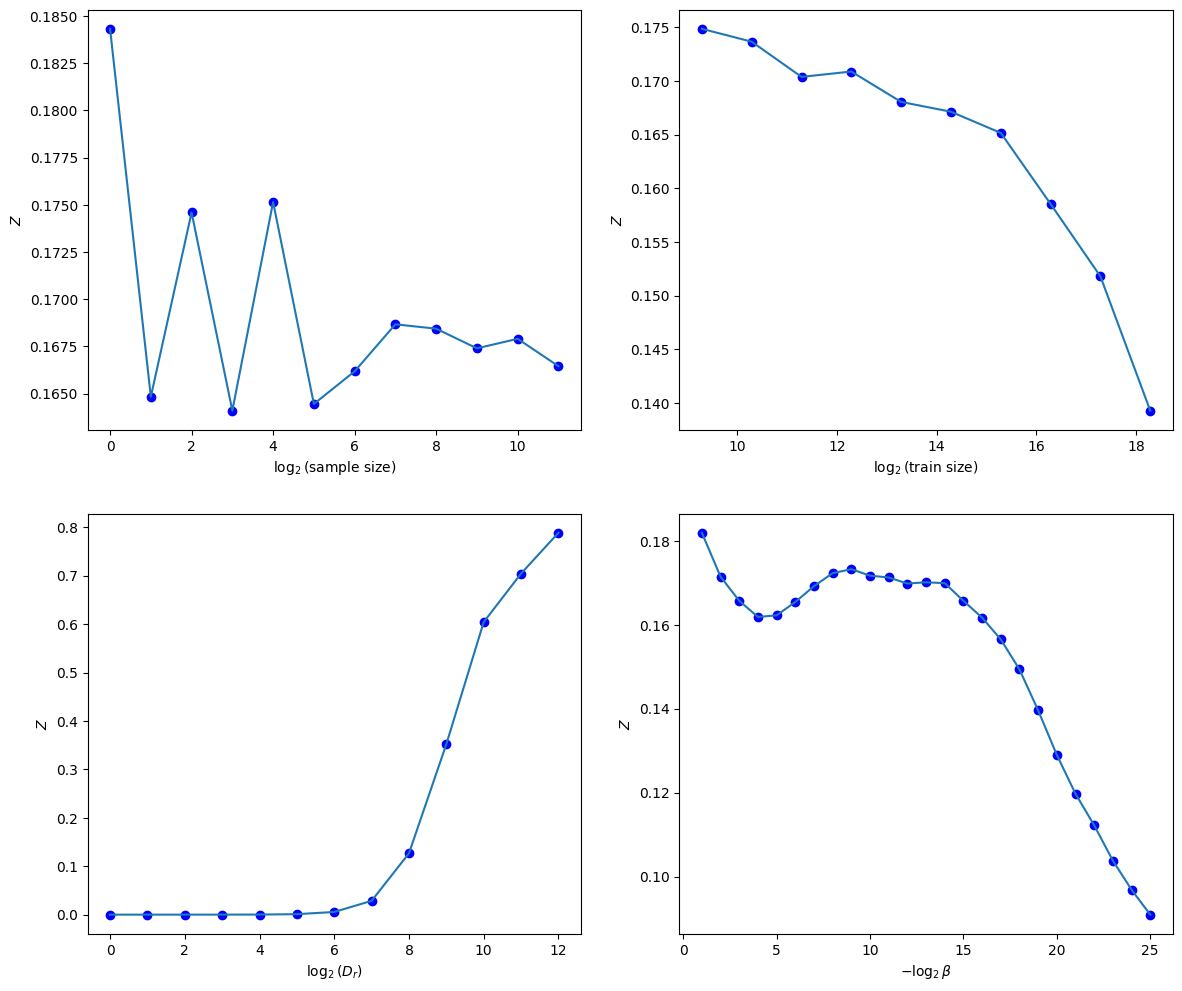

In [16]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

axs = [ax, ax1, ax2, ax3]

for i in range(4):
    mean = np.zeros(Ms[i])
    std = np.zeros(Ms[i])
    for j, item in enumerate(values[i]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        arr = bsa.get_data()['0_cols_W']
        mean[j] = arr.mean()
        # std[j] = arr.std()
    axs[i].plot(values_[i], mean, label=f'{vars[i]} ={item}')
    axs[i].scatter(values_[i], mean, c='b')
    axs[i].set_xlabel(f'{vars_[i]}')
    axs[i].set_ylabel(r'$Z$')

plt.savefig(f'../data/plots/mean_zero_cols.png')

**Q7: How is the distribution of $\tau_f$ related to the distribution of FLTEs?**

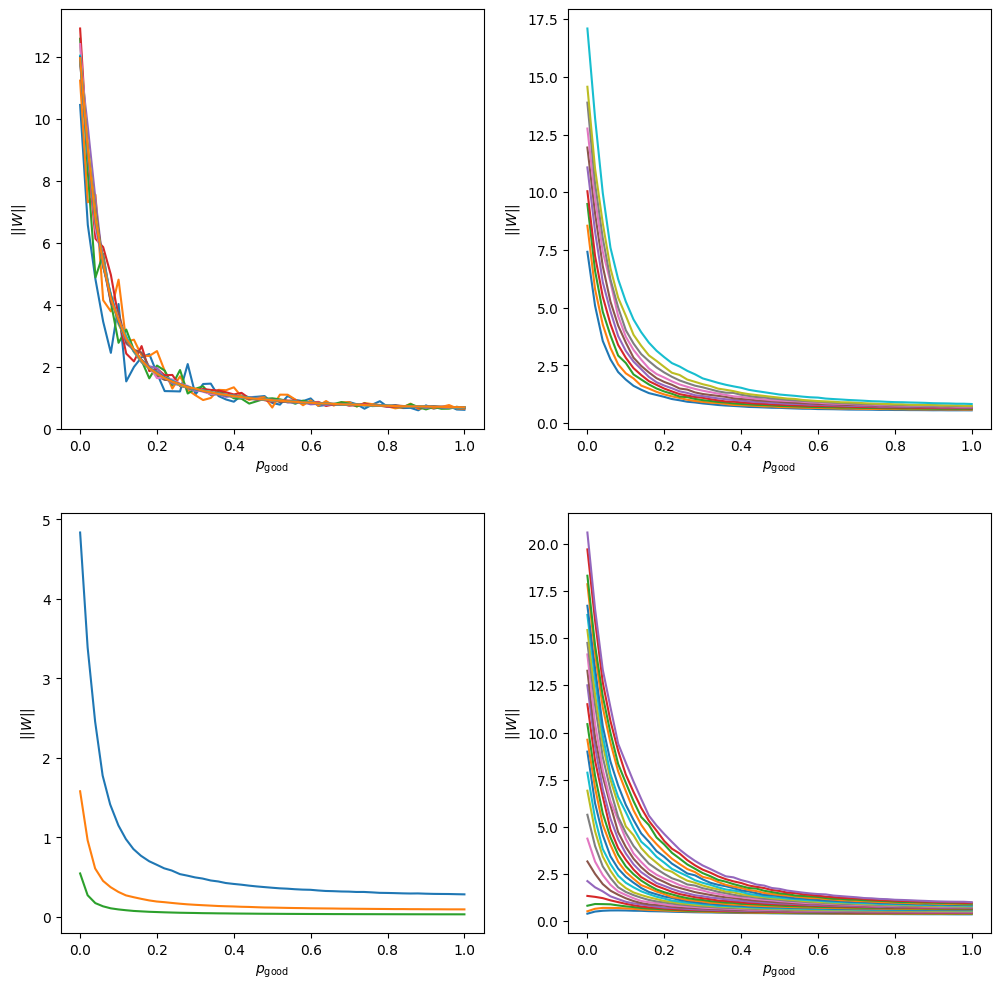

In [19]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs = [ax1, ax2, ax3, ax4]

save_folders = ['../data/L63-Strategy-varying-samplesize/', '../data/L63-Strategy-varying-trainsize/',\
                '../data/L63-Strategy-varying-featuresize/', '../data/L63-Strategy-varying-beta/']
Ms = [12, 10, 12, 25]
values = [[2**n for n in range(Ms[0])], [625*2**n for n in range(Ms[1])], [2**n for n in range(Ms[2])][-3:], [n for n in range(1, Ms[3]+1)]]
values_ = [[n for n in range(Ms[0])], [np.log2(625*2**n) for n in range(Ms[1])], [n for n in range(Ms[2])], [n for n in range(1, Ms[3]+1)]]
vars = ['sample size', 'train size', r'$D_r$', r'$-\log_2\beta$']
vars_ = [r'$\log_2(\text{sample size})$', r'$\log_2(\text{train size})$', r'$\log_2(D_r)$', r'$-\log_2\beta$']

p_last = np.zeros(Ms[-1])

for i in range(4):
    for j, item in enumerate(values[i]):
        
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        zc = bsa.get_line('||W||')[0]
        if i==3:
            p_last[j] = zc[-1]
        axs[i].plot(bsa.percents, zc, label=f'{vars[i]} ={item}')
        # axs[i].scatter(bsa.percents, zc, c='b')
    axs[i].set_xlabel(r'$p_{\rm good}$')
    axs[i].set_ylabel(r'$||W||$')
    # axs[i].legend(fontsize=7)
    # axs[i].set_aspect('equal')
plt.savefig(f'../data/plots/W_norm_vs_p_good.png')

In [ ]:
plt.scatter([n for n in values[-1]], p_last)

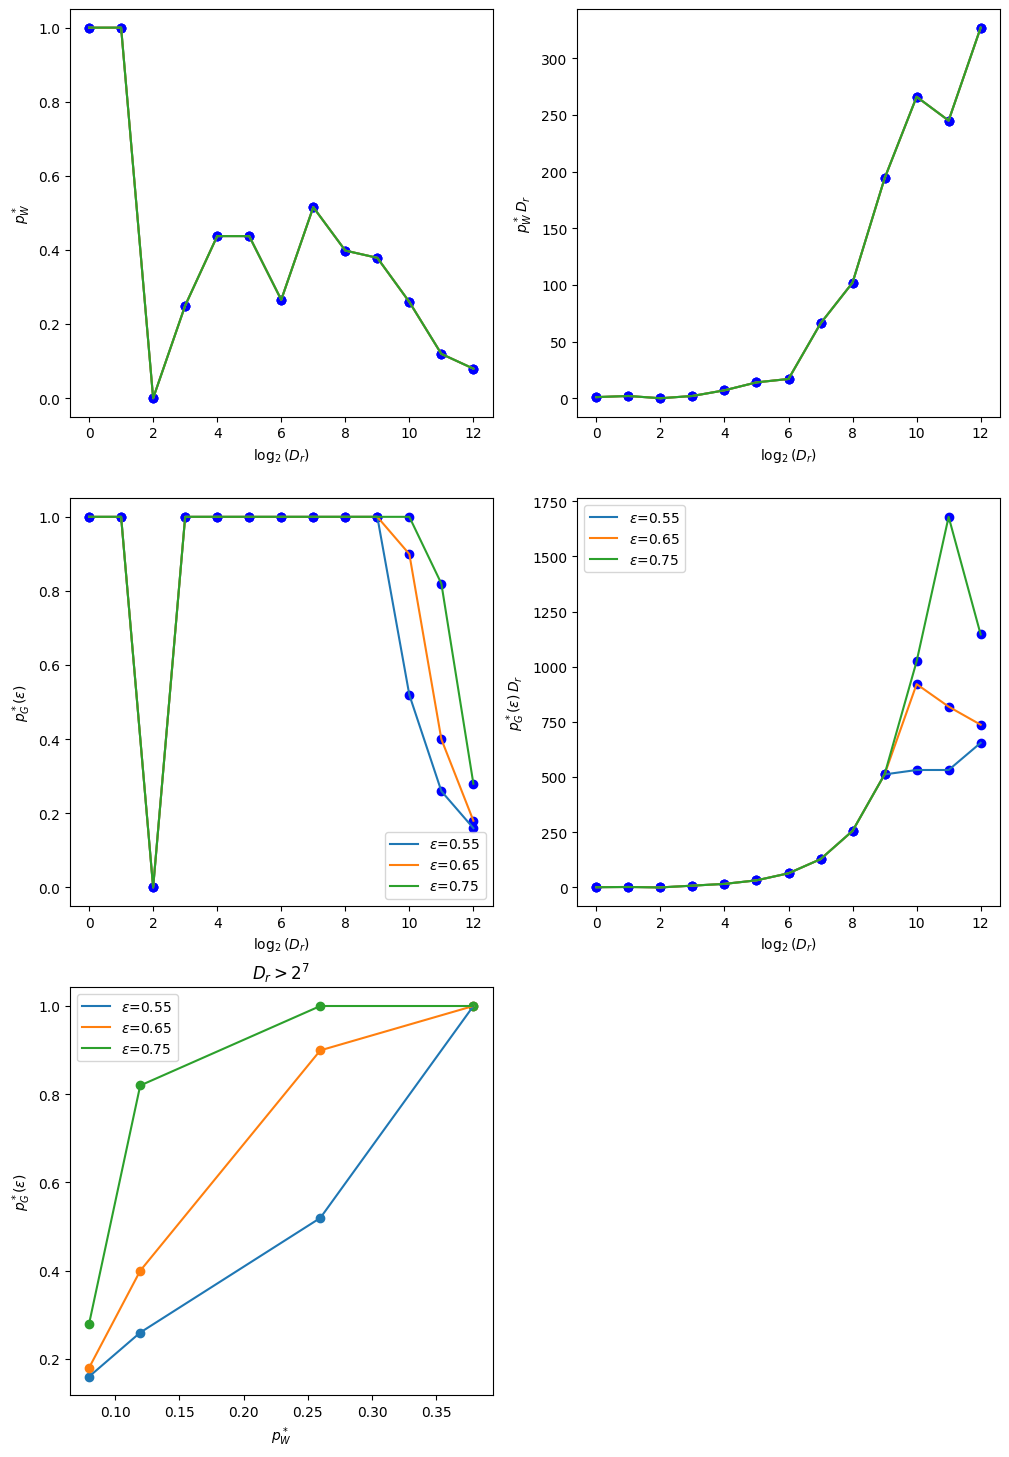

In [24]:
fig = plt.figure(figsize=(12, 18))
ax = fig.add_subplot(321)
ax1 = fig.add_subplot(322)
ax2 = fig.add_subplot(323)
ax3 = fig.add_subplot(324)
ax4 = fig.add_subplot(325)

Ms = [12, 10, 13, 25]
values = [[2**n for n in range(Ms[0])], [625*2**n for n in range(Ms[1])], [2**n for n in range(Ms[2])], [n for n in range(1, Ms[3]+1)]]
values_ = [[n for n in range(Ms[0])], [np.log2(625*2**n) for n in range(Ms[1])], [n for n in range(Ms[2])], [n for n in range(1, Ms[3]+1)]]

I = 2
tau_lim = 5.
p_W = np.zeros(Ms[I])
p_G = np.zeros(Ms[I]) 
for threshold in [0.55, 0.65, 0.75]:
    for i, D_r in enumerate(values[I]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[I] + str(D_r))
        p_G[i], p_W[i] = [bsa.percents[j] for j in bsa.compute_optimal_p(gen=tau_lim, threshold=threshold)]
    
    ax.plot(np.log2(values[I]), p_W, label=f'threshold={threshold}')
    ax.scatter(np.log2(values[I]), p_W, c='b')
    ax.set_xlabel(r'$\log_2(D_r)$')
    ax.set_ylabel(r'$p^*_{W}$')
    
    
    ax1.plot(np.log2(values[I]), (values[I])*(p_W), label=f'threshold={threshold}')
    ax1.scatter(np.log2(values[I]), (values[I])*(p_W), c='b')
    ax1.set_xlabel(r'$\log_2(D_r)$')
    ax1.set_ylabel(r'$p^*_{W}\,D_r$')

    ax2.plot(np.log2(values[I]), p_G, label=fr'$\varepsilon$={threshold}')
    ax2.scatter(np.log2(values[I]), p_G, c='b')
    ax2.set_xlabel(r'$\log_2(D_r)$')
    ax2.set_ylabel(r'$p^*_{G}(\varepsilon)$')
    
    
    ax3.plot(np.log2(values[I]), (values[I])*(p_G), label=fr'$\varepsilon$={threshold}')
    ax3.scatter(np.log2(values[I]), (values[I])*(p_G), c='b')
    ax3.set_xlabel(r'$\log_2(D_r)$')
    ax3.set_ylabel(r'$p^*_{G}(\varepsilon)\,D_r$')
    if True:#threshold == 0.65:
        ax4.plot(p_W[-4:], (p_G)[-4:], label=fr'$\varepsilon$={threshold}')
        ax4.scatter(p_W[-4:], (p_G)[-4:])
        ax4.set_xlabel(r'$p^*_W$')
        ax4.set_ylabel(r'$p^*_{G}(\varepsilon)$')
        ax4.set_title(r'$D_r>2^7$')

# ax.legend()
# ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig(f'../data/plots/optimal_p_vs_D_r_tau_f_5.png')

In [25]:
np.log2(p_W[-1]), np.log2(p_W[-2])

(-3.6468531745019175, -3.0633620609974295)

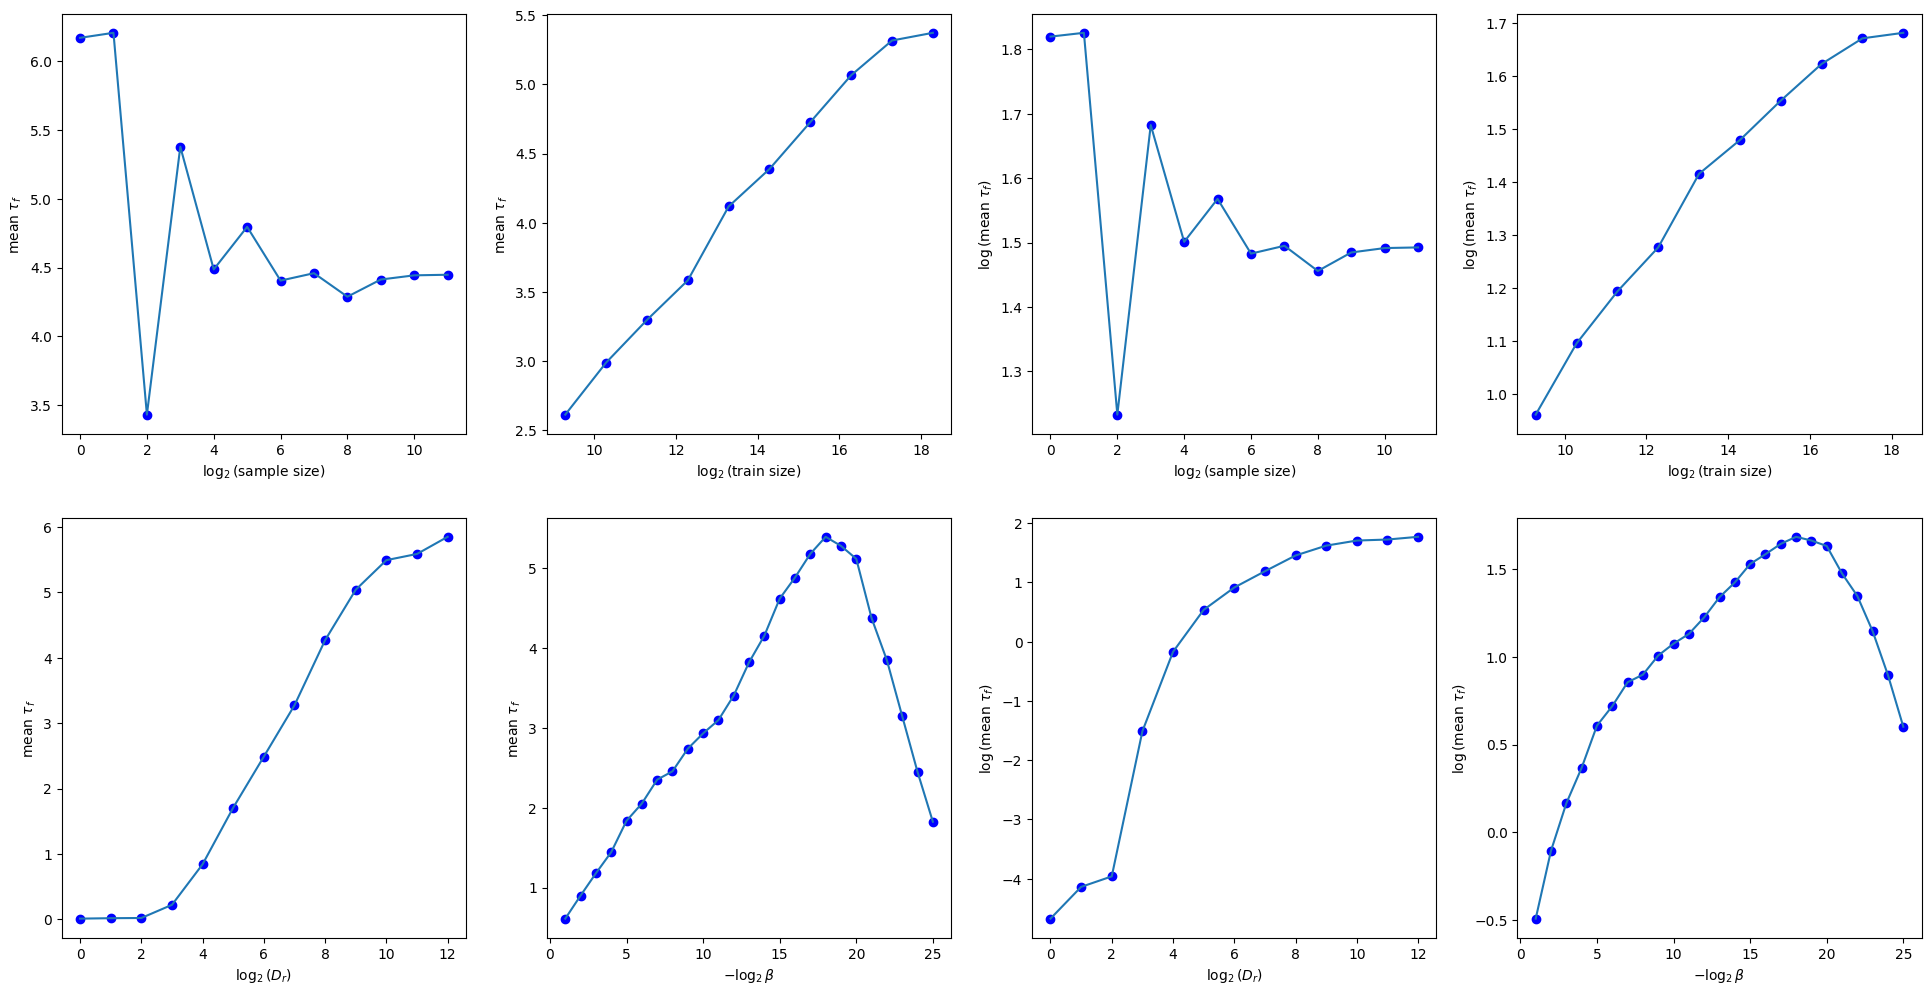

In [32]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(241)
ax1 = fig.add_subplot(242)
ax2 = fig.add_subplot(245)
ax3 = fig.add_subplot(246)

ax4 = fig.add_subplot(243)
ax5 = fig.add_subplot(244)
ax6 = fig.add_subplot(247)
ax7 = fig.add_subplot(248)

axs = [ax, ax1, ax2, ax3]
axs_ = [ax4, ax5, ax6, ax7]
for i in range(4):
    mean = np.zeros(Ms[i])
    std = np.zeros(Ms[i])
    for j, item in enumerate(values[i]):
        bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folders[i] + str(item))
        arr = bsa.get_data()
        arr = arr[arr['good_rows_W_in']==bsa.percents[-1]]
        arr = arr['tau_f_se']
        mean[j] = arr.mean()
        std[j] = arr.std()
    axs[i].plot(values_[i], mean, label=f'{vars[i]} ={item}')
    axs[i].scatter(values_[i], mean, c='b')
    axs[i].set_xlabel(f'{vars_[i]}')
    axs[i].set_ylabel(r'mean $\tau_f$')

    axs_[i].plot(values_[i], np.log(mean), label=f'{vars[i]} ={item}')
    axs_[i].scatter(values_[i], np.log(mean), c='b')
    axs_[i].set_xlabel(f'{vars_[i]}')
    axs_[i].set_ylabel(r'$\log$(mean $\tau_f$)')
plt.savefig(f'../data/plots/mean_tau_f.png')